# Notebook to choose the best model with the UMD data

In [5]:
# Imports general
import pandas as pd
import numpy as np
# from matplotlib import rcParams
# rcParams['font.sans-serif'] = 'DejaVu Sans'
import matplotlib.pyplot as plt
%matplotlib inline

# Imports scikit-learn
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import tree
from sklearn import svm
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Bespoke imports
import rail_utils
from rail_utils import PlotModels

In [6]:
# Load data
train_file = '../../data/processed/umd_data_standard_train.csv'
train_data = pd.read_csv(train_file)

# Define variables
admission_variables = ['gender_Male', 'ethnicity_Hispanic','ethnicity_Black', 'ethnicity_White', 'ethnicity_Asian', \
                       'term', 'bmi', 'age', 'allergies_Yes', 'asthma_Yes', 'gerd_Yes', 'tonsilsize_3-4', 'zscore']
test_variable = ['ahi']
continuous_variables = ["bmi", "age", 'zscore']
reference_variables = ['reference: osa18', 'reference: psq', 'reference: ess']

# Variables to ignore based on distributions
# ignore_variables = ['ethnicity Black', 'ethnicity Hispanic', 'gerd_Yes', 'tonsilsize_3-4', 'age']
ignore_variables = []

final_variables = list(set(admission_variables) - set(ignore_variables))
continuous_variables = list(set(continuous_variables) - set(ignore_variables))

# Set AHI threshold
ahi_thresh = 5

# Set up training set
ytrain = pd.Series(train_data['ahi']>ahi_thresh, index=train_data.index)
xtrain = train_data[final_variables]

In [7]:
# Initialise models
models = {\
'Logistic Regression l2 reg*': LogisticRegressionCV(penalty = 'l2', \
                                                    solver='liblinear', scoring='roc_auc', n_jobs=-1), \
'Logistic Regression l1 reg*': LogisticRegressionCV(penalty = 'l1', \
                                                    solver='liblinear', scoring='roc_auc', n_jobs=-1), \
'Logistic Regression': LogisticRegression(C=1e10), \
'Decision Trees': tree.DecisionTreeClassifier(criterion='gini'), \
'Random Forest': RandomForestClassifier(), \
'SVM linear': svm.SVC(probability=True, kernel='linear'), \
'SVM rbf': svm.SVC(probability=True, kernel='rbf'), \
'SVM linear reg': svm.SVC(probability=True, kernel='linear'), \
'SVM rbf reg': svm.SVC(probability=True, kernel='rbf'),
'Naive Bayes': GaussianNB(),
'Logistic regression l1 no cv': LogisticRegression(penalty='l1'),
'Logistic regression l2 no cv': LogisticRegression(penalty='l2')}

### First try models without feature engineering

Best model: Logistic regression l1 no cv (AUC: 0.752, Sens: 0.613, Spec: 0.778)


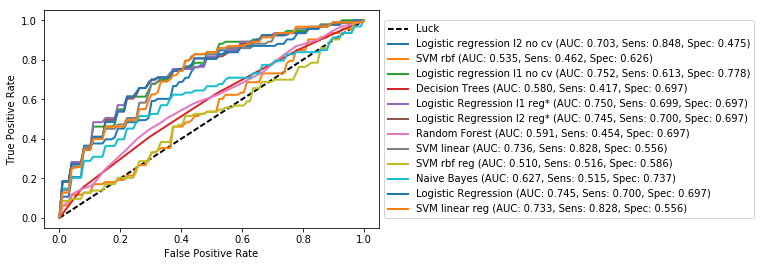

In [8]:
PlotModels(models=models, kfolds=5).fit(data = [xtrain, ytrain]).plot()

### Try normalise the data

Best model: SVM rbf reg (AUC: 0.780, Sens: 0.689, Spec: 0.778)


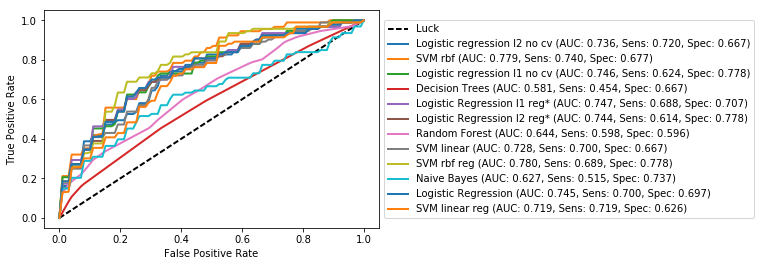

In [9]:
pipeline = [[preprocessing.StandardScaler(), continuous_variables]]

PlotModels(models=models, kfolds=5, pipeline=pipeline).fit(data = [xtrain, ytrain]).plot()

### Try model with PCA based feature reduction

Best model: Logistic Regression (AUC: 0.758, Sens: 0.774, Spec: 0.626)


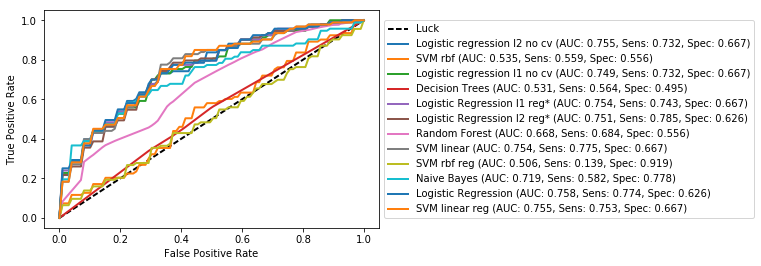

In [10]:
pipeline = [[PCA(n_components=10), 'all']]

PlotModels(models=models, kfolds=5, pipeline=pipeline).fit(data = [xtrain, ytrain]).plot()

### Try model with normalised data and PCA based feature reduction

Best model: SVM rbf (AUC: 0.787, Sens: 0.762, Spec: 0.677)


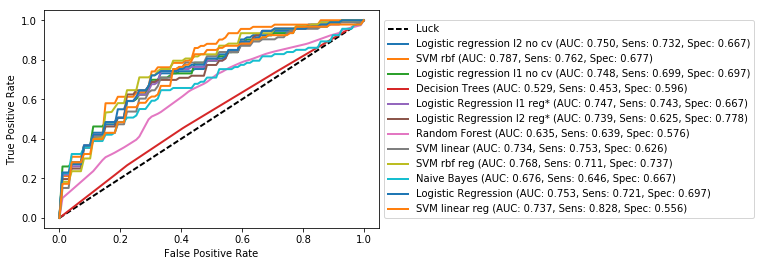

In [11]:
pipeline = [[preprocessing.StandardScaler(), continuous_variables], [PCA(n_components=11), 'all']]

PlotModels(models=models, kfolds=5, pipeline=pipeline).fit(data = [xtrain, ytrain]).plot()

### Try model with polynomial features and normalisation

Best model: SVM linear reg (AUC: 0.892, Sens: 0.860, Spec: 0.808)


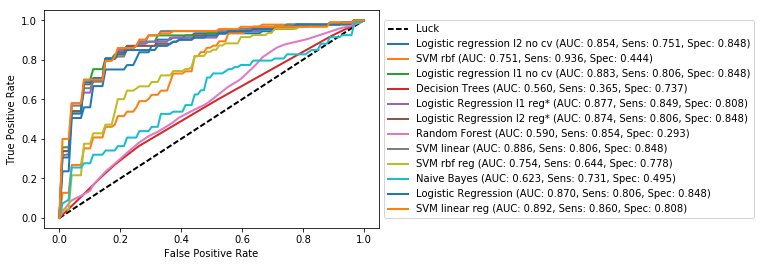

In [12]:
pipeline = [[preprocessing.StandardScaler(), continuous_variables],
            [preprocessing.PolynomialFeatures(degree=2), 'from before']]

PlotModels(models=models, kfolds=5, pipeline=pipeline).fit(data = [xtrain, ytrain]).plot()

### Try model with polynomial features, normalisation and PCA feature reduction on continuous variables

Best model: Logistic regression l1 no cv (AUC: 0.906, Sens: 0.850, Spec: 0.848)


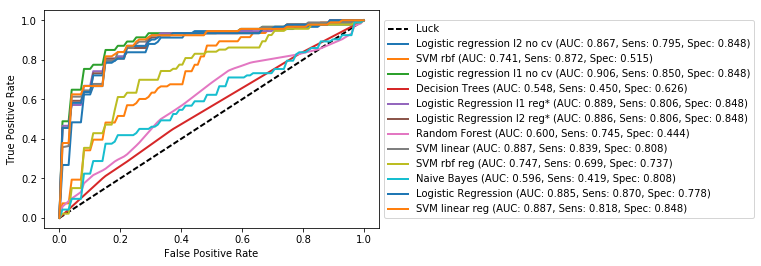

In [13]:
pipeline = [[preprocessing.StandardScaler(), continuous_variables],
            [preprocessing.PolynomialFeatures(degree=2), 'from before'],
            [PCA(n_components=6), 'from before']]

PlotModels(models=models, kfolds=5, pipeline=pipeline).fit(data = [xtrain, ytrain]).plot()

### Try model with polynomial features, normalisation (after polynomial features) and PCA feature reduction on continuous variables

Best model: Logistic Regression l1 reg* (AUC: 0.880, Sens: 0.795, Spec: 0.848)


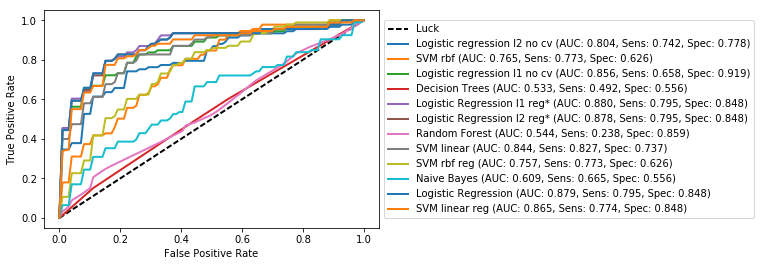

In [14]:
pipeline = [[preprocessing.PolynomialFeatures(degree=2), continuous_variables],
            [preprocessing.StandardScaler(), 'from before'],
            [PCA(n_components=6), 'from before']]

PlotModels(models=models, kfolds=5, pipeline=pipeline).fit(data = [xtrain, ytrain]).plot()

### Try model with polynomial features, normalisation and PCA feature reduction on all variables

Best model: Logistic Regression (AUC: 0.653, Sens: 0.277, Spec: 0.960)


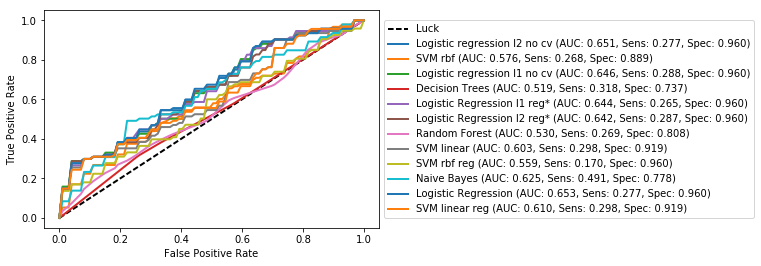

In [15]:
pipeline = [[preprocessing.StandardScaler(), continuous_variables],
            [preprocessing.PolynomialFeatures(degree=2), 'from before'],
            [PCA(n_components=6), 'all']]

PlotModels(models=models, kfolds=5, pipeline=pipeline).fit(data = [xtrain, ytrain]).plot()